In [44]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [2]:
# Set the path to your train, test, and predict directories
train_dir = "/content/drive/MyDrive/fruits/train"
test_dir = "/content/drive/MyDrive/fruits/test"
predict_dir = "/content/drive/MyDrive/fruits/predict"

# Define the number of classes and input shape
num_classes = 10
input_shape = (224, 224, 3)



In [3]:
# Data augmentation and preprocessing
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load and augment the train set
train_data = data_generator.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical'
)

# Load and preprocess the test set
test_data = data_generator.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load and preprocess the predict set
predict_data = data_generator.flow_from_directory(
    predict_dir,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 2301 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


In [4]:
import csv

# Load the pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# Freeze the pre-trained layers
base_model.trainable = False

# Create the classification model
model = keras.Sequential([
    base_model,
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)




94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/10
72/72 [==============================] - 2178s 30s/step - loss: 0.9766 - accuracy: 0.6814 - val_loss: 1.7415 - val_accuracy: 0.6712
Epoch 2/10
72/72 [==============================] - 55s 768ms/step - loss: 0.3885 - accuracy: 0.8688 - val_loss: 2.0270 - val_accuracy: 0.6761
Epoch 3/10
72/72 [==============================] - 51s 706ms/step - loss: 0.3091 - accuracy: 0.8922 - val_loss: 2.3104 - val_accuracy: 0.7063
Epoch 4/10
72/72 [==============================] - 53s 736ms/step - loss: 0.2713 - accuracy: 0.9083 - val_loss: 2.1122 - val_accuracy: 0.6985
Epoch 5/10
72/72 [==============================] - 51s 708ms/step - loss: 0.2209 - accuracy: 0.9274 - val_loss: 2.2624 - val_accuracy: 0.7005
Epoch 6/10
72/72 [==============================] - 50s 699ms/step - loss: 0.1924 - accuracy: 0.9383 - val_loss: 2.6081 - val_accuracy: 0.6907
Epoch 7/10
72/72 [==============================] - 56s 776ms/step - loss: 0.

In [38]:
import csv
dataset = []
# Function to extract features from an image
def extract_features(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array)
    return features.reshape((-1,))

# Function to save image features to a CSV file
def save_image_features_to_csv(dataset, csv_file_path):
    with open(csv_file_path, "w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)
        for image_path in dataset:
            features = extract_features(image_path)
            csv_writer.writerow([image_path] + list(features))

# Function to find similar images based on cosine similarity using a CSV file
def find_similar_image_from_csv(query_image_path, csv_file_path):
    query_features = extract_features(query_image_path)
    similar_images = []

    with open(csv_file_path, "r") as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            image_path = row[0]
            features = np.array(row[1:], dtype=np.float32)
            similarity = cosine_similarity([query_features], [features])[0][0]
            similar_images.append((image_path, similarity))

    similar_images.sort(key=lambda x: x[1], reverse=True)
    return similar_images


# Collect paths of all images in the train and test directories
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        dataset.append(image_path)

for class_dir in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_dir)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        dataset.append(image_path)


# Save image features to a CSV file
csv_file_path = "image_features_mod.csv"
save_image_features_to_csv(dataset, csv_file_path)



1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


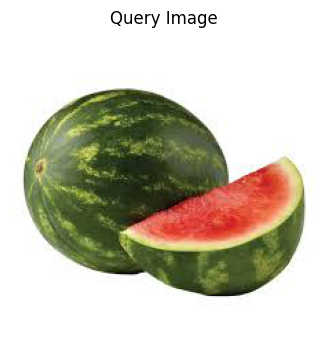

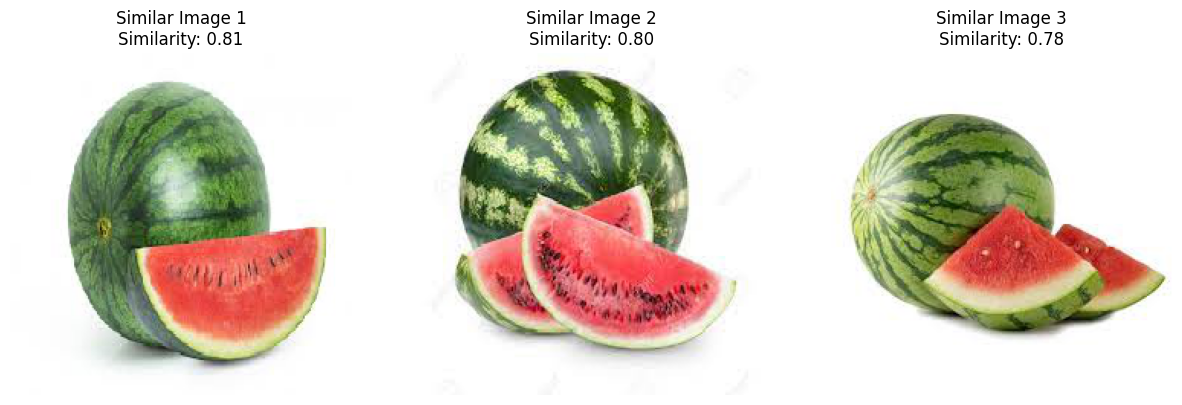

In [43]:
# Example usage
query_image = "/content/drive/MyDrive/fruits/predict/023.jpeg"

# Find similar images from the CSV file
similar_images = find_similar_image_from_csv(query_image, csv_file_path)

# Show the query image
query_img = keras.preprocessing.image.load_img(query_image, target_size=input_shape[:2])
plt.figure(figsize=(4, 4))
plt.imshow(query_img)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Show the similar images
plt.figure(figsize=(15, 5))
for i in range(3):
    image_path, similarity = similar_images[i]
    similar_img = keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
    plt.subplot(1, 3, i+1)
    plt.imshow(similar_img)
    plt.title(f"Similar Image {i+1}\nSimilarity: {similarity:.2f}")
    plt.axis('off')
plt.show()

